# Imports

In [1]:
from torch import nn
import torch
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import pickle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Criando o dataset

In [2]:
with open('dataset.pickle', 'rb') as handle:
    ds_file = pickle.load(handle)

In [3]:
ds_file.keys()

dict_keys(['treino', 'validacao', 'teste'])

In [4]:
class CatsXDogsDataset(Dataset):
    
    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # pq? https://pytorch.org/docs/stable/torchvision/models.html
                            std=[0.229, 0.224, 0.225])
    ])
    
    def __init__(self, files_list: list):
        self.files_list = files_list
    
    def __len__(self):
        return len(self.files_list)
    
    def __getitem__(self, idx):
        file_name = self.files_list[idx]
        folder_path = '../data/cats/' if 'cat' in file_name else '../data/dogs/'
    
        image = Image.open(folder_path+file_name).resize(2*(256,))
        label = 0 if 'cat' in file_name else 1
        return self.tfms(image), torch.tensor(label).float()

In [5]:
ds_train = CatsXDogsDataset(ds_file['treino'])
ds_valid = CatsXDogsDataset(ds_file['validacao'])

In [6]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=16)

In [7]:
x, y = next(iter(dl_train))

In [8]:
grid = make_grid(x, nrow=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


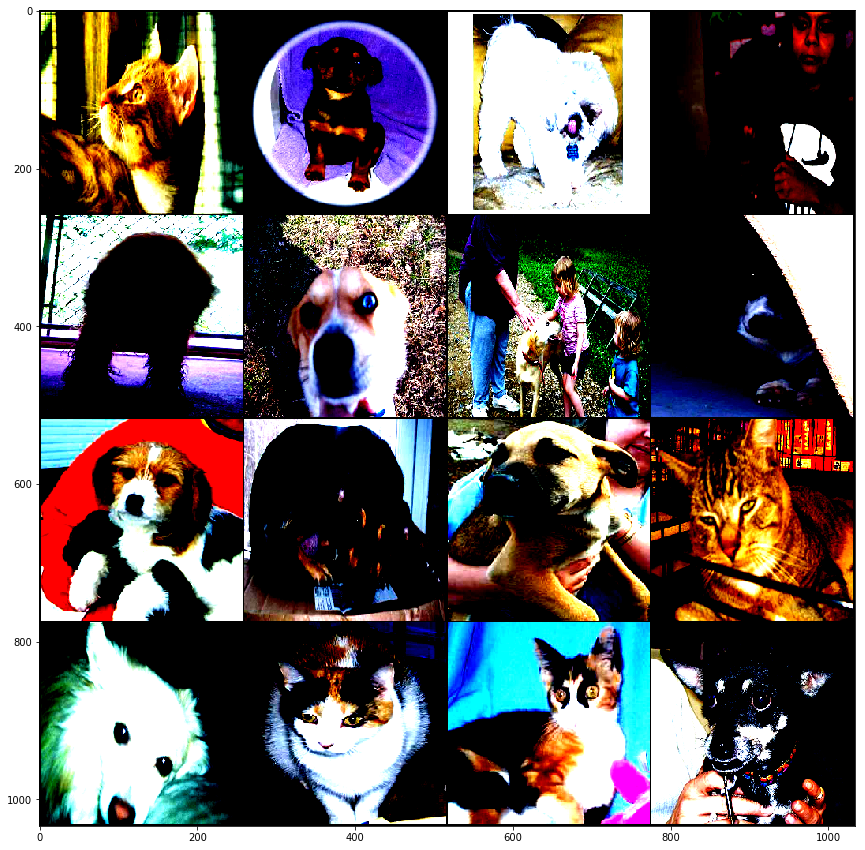

In [9]:
plt.figure(figsize=(15, 15))
plt.imshow(grid.numpy().transpose(1, 2, 0))

In [10]:
y, y.shape

(tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.]),
 torch.Size([16]))

# O modelo

In [11]:
class CatXDogModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-2])
        self.conv1 = nn.Conv2d(512, 1, kernel_size=8)
        
    def forward(self, x):
        x = self.resnet(x)
        return self.conv1(x).squeeze()

In [12]:
model = CatXDogModel()

In [13]:
model

CatXDogModel(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [14]:
x.shape

torch.Size([16, 3, 256, 256])

In [15]:
out = model(x)

In [16]:
prob = torch.sigmoid(out)
prob

tensor([0.2209, 0.5309, 0.7623, 0.5254, 0.8340, 0.6770, 0.4747, 0.7409, 0.4786,
        0.6406, 0.6114, 0.3714, 0.6743, 0.7359, 0.4586, 0.3965],
       grad_fn=<SigmoidBackward>)

# Loss

In [17]:
loss_fn = nn.BCEWithLogitsLoss()

In [18]:
loss = loss_fn(out, y)
loss

tensor(0.5574, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

# Optimizador

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Propagando loss

In [20]:
loss.backward()
optimizer.step()
optimizer.zero_grad()

In [21]:
out = model(x)
loss = loss_fn(out, y)
loss

tensor(0.3854, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [ ]:
# Melhorou